## 3. Hybrid Quantum-Classical Model

We now build a hybrid model combining a classical neural network with a quantum layer. The classical component uses an LSTM to extract temporal features. The quantum component is a variational quantum circuit (VQC) that acts as a nonlinear transformation layer.

We use the `PennyLane` library to construct the quantum circuit and integrate it with `PyTorch` for training.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm import tqdm
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchview import draw_graph
from IPython.display import Image, display



In [2]:
# Download historical stock data (Apple Inc. as example)
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")


# Flatten MultiIndex columns
data.columns = data.columns.get_level_values(0)

# Use 'Close' as the main signal
data = data[['Close']].copy()
data.rename(columns={'Close': 'price'}, inplace=True)

# Forward-fill missing data (e.g., for non-trading days)
data.ffill(inplace=True)

# normalize the data to the [0, 1] range using Min-Max scaling.
scaler = MinMaxScaler()
data['normalized'] = scaler.fit_transform(data[['price']])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


**Data Parameters**

In [3]:
# Use a window size (e.g., 20)
WINDOW_SIZE = 20

In [4]:
# To perform time series forecasting, we convert the normalized series into input/output sequences 
# using a sliding window approach.
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)


series = data['normalized'].values
X, y = create_sequences(series, WINDOW_SIZE)

# split the data into training and testing sets.
# For example, we may use the last 20% of the sequences for testing.
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training sequences: {X_train.shape}")
print(f"Test sequences: {X_test.shape}")



Training sequences: (1996, 20)
Test sequences: (499, 20)


### 3.1 Quantum Circuit Definition

We define a variational quantum circuit using angle encoding and a simple entangling layer. This circuit will act as a nonlinear layer in the hybrid model.



**Quantum Circuit Hyperparameters**

In [5]:
n_qubits = 2 # number of qubits
q_depth  = 2 # number of layers
n_rot_params = 3  # <--- number of rotation parameters per qubit (e.g. 1 for RY, 3 for Rot)

# draw quantum circuit
draw_qc_bool = True

# draw the QML or ML model graph
draw_model_graph = True

# wether to use quantum or classical model
use_quantum = True

In [6]:
# Device definition
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights, draw=False):
    """
    Variational quantum circuit for hybrid model.
    
    Args:
        inputs (Tensor): Input features (size ≤ n_qubits)
        weights (Tensor): Trainable parameters of shape (q_depth, n_qubits, n_rot_params)
        draw (bool): If True, draw the circuit once (ASCII + matplotlib)
        
    Returns:
        List[Expectation values] for PauliZ on each qubit
    """
    # --- Input Encoding ---
    encoded_inputs = inputs[:n_qubits]
    for i in range(n_qubits):
        qml.RY(encoded_inputs[i], wires=i)
    
    # Optionally, use this instead:
    # qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # --- Variational Layers ---
    for layer in range(q_depth):
        for i in range(n_qubits):
            if n_rot_params == 1:
                qml.RY(weights[layer][i][0], wires=i)
            elif n_rot_params == 2:
                qml.RX(weights[layer][i][0], wires=i)
                qml.RZ(weights[layer][i][1], wires=i)
            elif n_rot_params == 3:
                qml.Rot(*weights[layer][i], wires=i)
            else:
                raise ValueError("n_rot_params must be 1, 2, or 3.")

        # Entanglement (ring topology)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # --- Optional Drawing ---
    if draw:       
        try:
            fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
            fig.tight_layout()
            fig.show()
        except Exception as e:
            print("⚠️ MPL circuit draw failed:", e)

    # --- Measurement ---
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


C:\Users\npace\AppData\Local\Temp\ipykernel_32732\2088329115.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\npace\AppData\Local\Temp\ipykernel_32732\2088329115.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


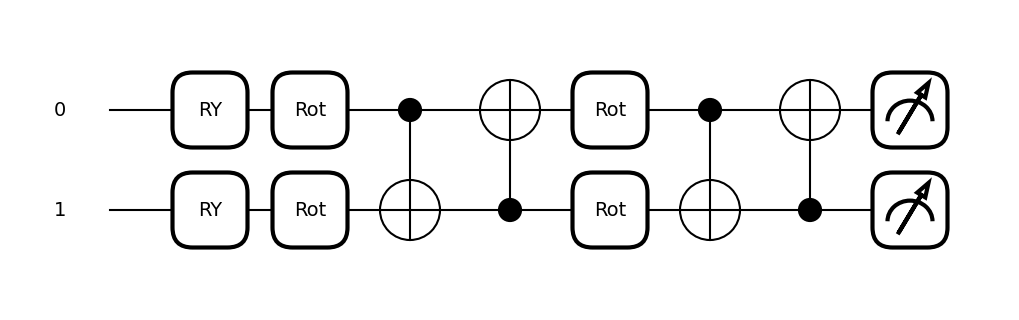

In [7]:
sample_input = torch.randn(n_qubits)
sample_weights = torch.randn(q_depth, n_qubits, n_rot_params)

_ = quantum_circuit(sample_input, sample_weights, draw=draw_qc_bool)


In [8]:
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, q_depth, n_rot_params):
        super().__init__()

        # Initialize trainable parameters for the quantum circuit
        # Shape: [q_depth, n_qubits, n_rot_params] (rotation angles per qubit per layer)
        q_init = torch.empty(q_depth, n_qubits, n_rot_params)
        torch.nn.init.normal_(q_init, mean=0.0, std=0.01)  # Small init to avoid flat gradients
        self.q_params = nn.Parameter(q_init)

        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.n_rot_params = n_rot_params

    def forward(self, x_batch):
        """
        Apply the quantum circuit to each sample in the batch.

        Args:
            x_batch (Tensor): Input of shape [batch_size, n_qubits]

        Returns:
            Tensor: Output of shape [batch_size, n_qubits]
        """
        outputs = []
        for x in x_batch:
            # Apply the quantum circuit to each sample
            q_out = quantum_circuit(x, self.q_params)

            # Convert list of expectation values into a float32 tensor
            q_tensor = torch.stack(q_out).to(dtype=torch.float32)

            outputs.append(q_tensor)

        # Stack the results into a batch tensor
        return torch.stack(outputs)


**Dummy Class for visualizing the Quantum Layer**

In [27]:
class VisualQuantumLayer(nn.Module):
    def __init__(self, out_features, in_features=None, label="QuantumLayer", n_qubits=2, q_depth=1, n_rot_params=3):
        super().__init__()
        self.out_features = out_features
        self.in_features = in_features or out_features

        # 🧠 Add these to match real QuantumLayer
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.n_rot_params = n_rot_params

        self.dummy = nn.Linear(self.in_features, self.out_features, bias=False)
        for param in self.dummy.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.dummy(x)


In [10]:
class HybridQNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 n_qubits=4, q_depth=1, n_rot_params=3, use_quantum=True,
                 post_quantum_activation=None, skip_connection="concat"):
        super().__init__()
        
        self.use_quantum = use_quantum
        self.post_quantum_activation = post_quantum_activation  # 👈 Store this
        self.skip_connection = skip_connection  # 👈 Store this
        self.n_qubits = n_qubits  # 👈 Store this

        # LSTM layer to process input sequences
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        # Linear layer to map LSTM output to quantum layer input size
        self.linear1 = nn.Linear(hidden_size, n_qubits)

        # Optional quantum layer for variational feature extraction
        if use_quantum:
            if torch.jit.is_scripting() or torch.jit.is_tracing():
                # Use dummy version during tracing
                self.quantum = VisualQuantumLayer(n_qubits)
            else:
                self.quantum = QuantumLayer(n_qubits=n_qubits, q_depth=q_depth, n_rot_params=n_rot_params)

        # Output layer: expects concatenated quantum + classical output
        self.linear2 = nn.Linear(2 * n_qubits, output_size)

        # Final activation (can be changed to match your task)
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        # Input shape check: should be (batch_size, sequence_length, input_size)
        if len(x.shape) != 3:
            raise ValueError(f"Expected input shape (batch_size, seq_len, input_size), got {x.shape}")

        # Run input through LSTM
        lstm_out, _ = self.lstm(x)

        # Use the final hidden state of the sequence
        last_hidden = lstm_out[:, -1, :]

        # Project to quantum input dimension
        reduced = self.linear1(last_hidden)

        # Apply quantum layer if enabled
        if self.use_quantum:
            quantum_out = self.quantum(reduced)
            
            if self.post_quantum_activation == "ReLU":
                quantum_out = torch.relu(quantum_out)
                
            elif self.post_quantum_activation == "Tanh":
                quantum_out = torch.tanh(quantum_out)
                
            elif self.post_quantum_activation == "Sigmoid":
                quantum_out = torch.sigmoid(quantum_out)
        
        else:
            quantum_out = reduced  # fallback to classical-only path

        # Concatenate classical and quantum outputs
        x_out = torch.cat([quantum_out, reduced], dim=1)

        # Final linear projection
        out = self.linear2(x_out)

        return out


## 4. Training the Hybrid Quantum-Classical Model

In this section, we convert our data to PyTorch tensors, define a loss function and optimizer, and train the hybrid model over multiple epochs. The model will learn to predict the next price value based on prior values in the sequence.


In [11]:

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch, seq, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


**Model Hyperparameters**

In [12]:
# Set model hyperparameters
input_size = 1
hidden_size = 16
output_size = 1

num_epochs = 5

# === Early Stopping Config ===
early_stop_patience = 2 # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0

In [13]:


sequence_length = X_train.shape[1]

# Instantiate the model
model = HybridQNN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    n_qubits=n_qubits,
    q_depth=q_depth,
    n_rot_params=n_rot_params,
    use_quantum=use_quantum  # Set to True for quantum model
)

#use GPU if available **TODO**
    
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Visualize the Model

(LSTM → Linear → Quantum → Merge → Output)


(process:32140): Pango-WARNING **: 15:05:59.427: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


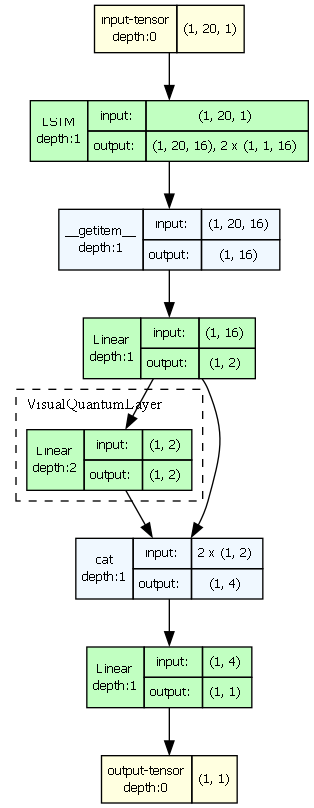

In [29]:
if draw_model_graph:
    # 🔁 Swap the quantum layer just for visualization
    model.quantum = VisualQuantumLayer(
        out_features=n_qubits,
        in_features=n_qubits,
        n_qubits=n_qubits,
        q_depth=q_depth,
        n_rot_params=n_rot_params
    )

    viz_model = draw_graph(
        model,
        input_size=(1, sequence_length, input_size),
        expand_nested=True,
        graph_name="Hybrid QNN with Quantum Block",
        roll=True,
        save_graph=False
    )


    # ⬇️ Use .pipe() to get PNG in memory
    png_bytes = viz_model.visual_graph.pipe(format="png")

    # ⬇️ Display it directly in notebook without saving
    display(Image(data=png_bytes))


### 🔁 4.1 Training Loop

We train the model for a number of epochs using Mean Squared Error (MSE) loss. During each epoch, we record the training loss to monitor convergence.


In [15]:
# Training loop
# Use tqdm for progress bar in each epoch
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Use tqdm for progress bar in each epoch
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for X_batch, y_batch in train_loader_tqdm:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Validation ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"📘 Epoch {epoch+1:3d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # === Early Stopping Check ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Optional: save model checkpoint
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        print(f"⚠️  No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= early_stop_patience:
        print("⛔ Early stopping triggered.")
        break


📘 Epoch   1 | Train Loss: 0.039331 | Val Loss: 0.190244


📘 Epoch   2 | Train Loss: 0.007857 | Val Loss: 0.023849


📘 Epoch   3 | Train Loss: 0.000660 | Val Loss: 0.019402


📘 Epoch   4 | Train Loss: 0.000457 | Val Loss: 0.013915


📘 Epoch   5 | Train Loss: 0.000347 | Val Loss: 0.010860


📈 Plot Training Loss
Code Cell:

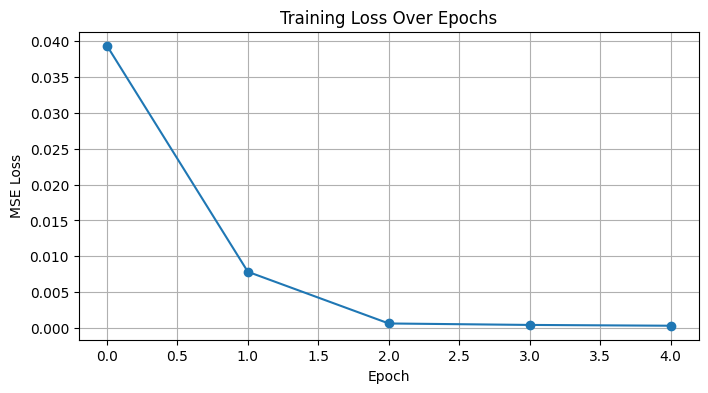

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


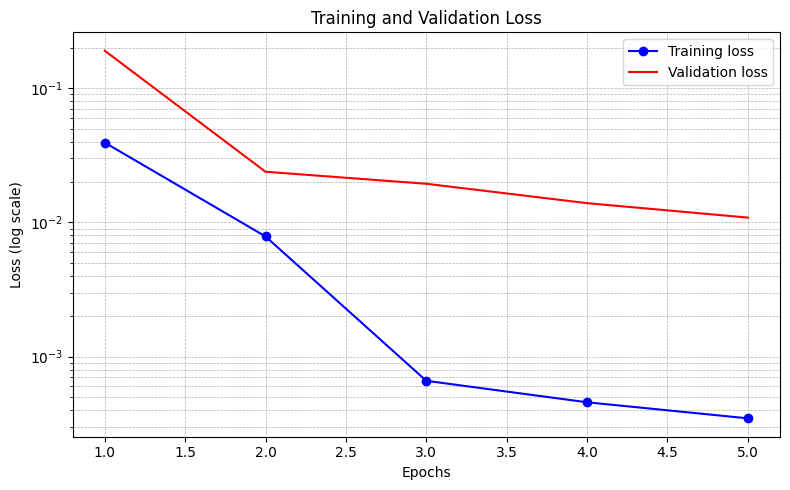

In [17]:

epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'r-', label='Validation loss')
plt.yscale('log')  # Log scale for better visibility of trends
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## 5. Evaluation and Prediction

Now that the hybrid model has been trained, we evaluate its performance on the test set and visualize the predicted vs actual values. This helps us assess how well the model generalizes to unseen data.


✅ Loaded best model from checkpoint for final evaluation.


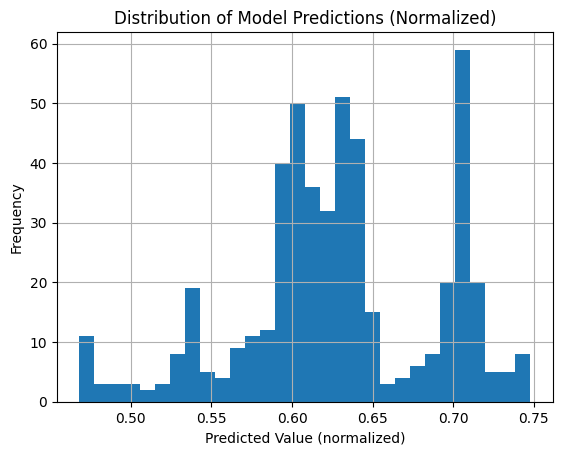

In [18]:
# === Load the best model for testing/prediction ===
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
print("✅ Loaded best model from checkpoint for final evaluation.")

predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred.detach().cpu())

# Concatenate and flatten
predictions = torch.cat(predictions).squeeze().numpy()
y_true = y_test_tensor.squeeze().cpu().numpy()

# Now plot the distribution
plt.hist(predictions, bins=30)
plt.title("Distribution of Model Predictions (Normalized)")
plt.xlabel("Predicted Value (normalized)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


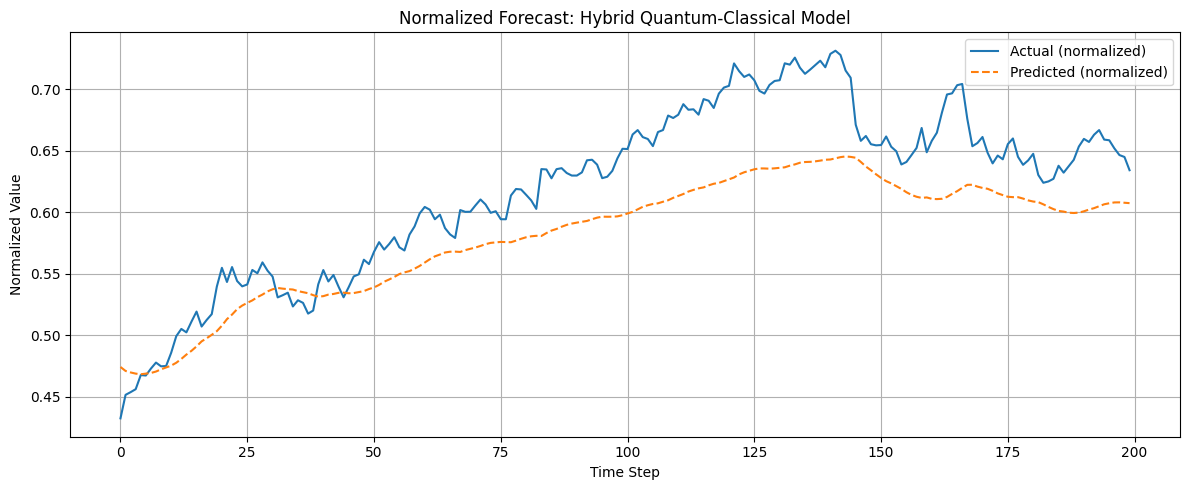

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(y_true[:200], label="Actual (normalized)")
plt.plot(predictions[:200], label="Predicted (normalized)", linestyle='--')
plt.title("Normalized Forecast: Hybrid Quantum-Classical Model")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
print("Scaler data min:", scaler.data_min_)
print("Scaler data max:", scaler.data_max_)

Scaler data min: [20.67453003]
Scaler data max: [258.73550415]


**🔄 Inverse Transform (Denormalize)**

In [21]:
# Reshape for inverse_transform (must be 2D)
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
true_prices = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()



### 5.1 Plot Forecasted vs Actual Prices
We now visualize how well the model’s predictions match the ground truth prices over time.


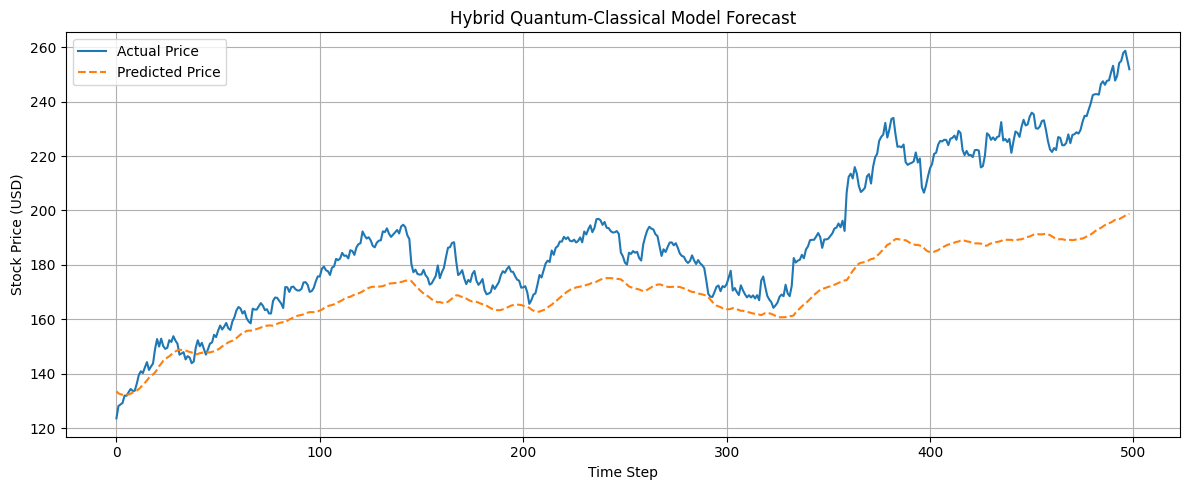

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(true_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price', linestyle='--')
plt.title("Hybrid Quantum-Classical Model Forecast")
plt.xlabel("Time Step")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5.2 Evaluation Metrics

We compute standard forecasting error metrics to quantify model performance.


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(true_prices, predicted_prices)
rmse = mean_squared_error(true_prices, predicted_prices, squared=False)

print(f"📈 Test MAE  = {mae:.4f}")
print(f"📈 Test RMSE = {rmse:.4f}")


📈 Test MAE  = 18.9785
📈 Test RMSE = 23.5636


c:\Users\npace\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


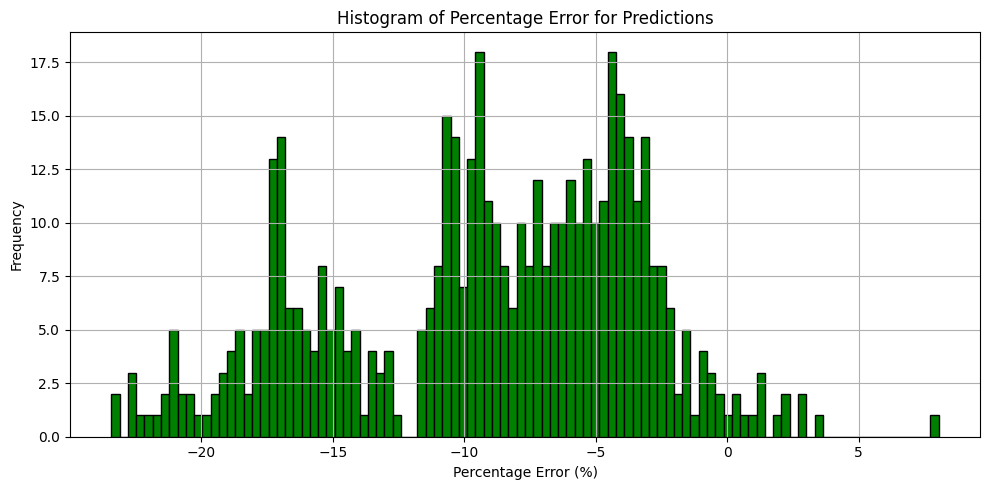

In [24]:


# Compute percentage errors
percentage_errors = 100 * (predicted_prices - true_prices) / true_prices

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(percentage_errors, bins=100, color='green', edgecolor='black')
plt.title("Histogram of Percentage Error for Predictions")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


### 📊 Logging Expiremental Results to Excel 

In [ ]:

def log_experiment(model, window_size, num_epochs, patience,
                   avg_train_loss, avg_val_loss, mae, rmse,
                   notes=""):
    # Extract dynamic fields
    use_quantum = getattr(model, "use_quantum", False)
    
    post_quantum_activation = getattr(model, "post_quantum_activation", None)
    skip_connection = getattr(model, "skip_connection", None)

    lstm_layers = getattr(model.lstm, "num_layers", 1)
    hidden_size = getattr(model.lstm, "hidden_size", None)
    final_activation = model.output_activation.__class__.__name__

    if use_quantum:
        n_qubits = model.quantum.n_qubits
        q_depth = model.quantum.q_depth
        n_rot_params = model.quantum.n_rot_params
    else:
        n_qubits = "-"
        q_depth = "-"
        n_rot_params = "-"

    # Optional: support GRU
    gru_layers = getattr(model, "gru_layers", 0)

    # Load or initialize
    try:
        df = pd.read_excel("qml_experiment_log.xlsx")
        next_id = df["Experiment ID"].max() + 1
    except FileNotFoundError:
        df = pd.DataFrame()
        next_id = 1

    # Add entry
    new_result = {
        "Experiment ID": next_id,
        "Description": f"Auto-logged: Q={n_qubits}, D={q_depth}, Skip={skip_connection}",
        "LSTM Layers": lstm_layers,
        "GRU Layers": gru_layers,
        "Hidden Size": hidden_size,
        "Window Size": window_size,
        "Num Epochs": num_epochs,
        "Early Stop Patience": patience,
        "Use Quantum": use_quantum,
        "Qubits": n_qubits,
        "Q Depth": q_depth,
        "Rotation Params": n_rot_params,
        "Skip Connection": skip_connection,
        "Post-Quantum Activation": post_quantum_activation,
        "Final Activation": final_activation,
        "Train Loss": avg_train_loss,
        "Validation Loss": avg_val_loss,
        "MAE": mae,
        "RMSE": rmse,
        "Notes": notes
    }

    df = pd.concat([df, pd.DataFrame([new_result])], ignore_index=True)
    df.to_excel("qml_experiment_log.xlsx", index=False)
    print(f"✅ Experiment logged as ID {next_id}")



In [30]:
log_experiment(
    model=model,
    window_size=WINDOW_SIZE,
    num_epochs=num_epochs,
    patience=early_stop_patience,
    avg_train_loss=avg_train_loss,
    avg_val_loss=avg_val_loss,
    mae=mae,
    rmse=rmse,
    notes="Fully dynamic logging"
)


✅ Experiment logged as ID 1
